In [14]:
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import curve_fit as curve_fit
from scipy.stats import norm
import scipy.integrate as integrate
from scipy.stats import norm

from astropy.table import Table

import emcee
import time
import corner
import herschelhelp
from matplotlib.colors import LogNorm

In [3]:
def get_center(bins):
    """
    Get the central positions for an array defining bins
    """
    return (bins[:-1] + bins[1:]) / 2

In [4]:
def num_problem(array):
    num_nan = np.sum(np.isnan(array))
    num_inf = np.sum(np.isinf(array))
    return(num_nan,num_inf)

In [5]:
def gaussian_pdf(x,params):
    mean,sig = params
    return(1/(np.sqrt(2*np.pi)*sig)*np.exp(-((x-mean)**2/(2*sig**2))))

In [6]:
def gaus_cdf(x,params):
    mean,sig = params
    return(norm.cdf(x,mean,sig))

In [7]:
def straight_line_gaus(x,y,params):
    m,c,sig = params
    return(1/(np.sqrt(2*np.pi)*sig)*np.exp(-((y-(m*x+c))**2/(2*sig**2))))

In [8]:
def agn_luminosity_function(L):
    #returns N for the luminsity function from Heckman and Best 2014 page 615
    A = 10**(-5.33)
    P0 = 10**24.95
    alpha = 0.42
    beta = 1.66
    
    N = A/((L/P0)**alpha + (L/P0)**beta)
    return(N)

In [9]:
def sf_luminosity_function(L):
    #returns the luminosity function from Mauch and Sadler 2007
    C = 10**(-2.83)
    P0 = 10**(21.18)
    sig = 0.6
    alpha = 1.02
    
    N = C*(L/P0)**(1-alpha) * np.exp(-0.5*((np.log10(1+L/P0)/sig)**2))
    return(N)

In [10]:
def mcmc_sample_from_pdf(func,N,xmin,xmax,ymin,ymax):
    x = []
    for n in range(N):
        x.append(random.random())
    x = np.array(x)
    x = x+xmin + (x*(xmax-xmin))

    y = []
    for n in range(N):
        y.append(random.random())
    y = np.array(y)
    y = y+ymin + (y*(ymax-ymin))
    
    test = func(10**x)
    mask = y<np.log10(test)
    
    return(x[mask])

In [11]:
def get_fir_lum(L,q,sig):
    #given the radio luminosity of a source (in W) it will return a FIR luminosity based on a FIRC 
    #from a given q value and scatter sig
    noise = np.random.normal(0,sig,len(L))
    q = q + noise
    fir = q + np.log10(L) + np.log10(3.75E12)
    return(fir)

In [12]:
def calc_Q(l_fir,l_rad):
    Q = np.log10(l_fir/3.75E12) - np.log10(l_rad)
    return(Q)

In [13]:
def straight_line_gaus_with_selection(x,y,params):
    m_sf,c_sf,sig_sf,m_agn,c_agn,sig_agn,sf_prop_0,sf_prop_1,sf_prop_2,sf_prop_3,sf_prop_4,sf_prop_5,sf_prop_6,sf_prop_7,sf_prop_8,sf_prop_9,cdf_mean,cdf_sig = params
    params_sf  = [m_sf,c_sf,sig_sf]
    params_agn = [m_agn,c_agn,sig_agn]
    sf_prop = np.array([sf_prop_0,sf_prop_1,sf_prop_2,sf_prop_3,sf_prop_4,sf_prop_5,sf_prop_6,sf_prop_7,sf_prop_8,sf_prop_9])
    params_cdf = [cdf_mean,cdf_sig]
    
    bins=np.arange(20,30,1)
    sf_prop_bin_in = np.digitize(x,bins=bins)
    #NEED TO ACCOUNT FOR ERRORS ON BINS WITH NO DATA IN THEM WHICH ARE GIVEN AN ERROR OF 0
    model = (sf_prop[sf_prop_bin_in-1]*straight_line_gaus(x,y,params_sf) + (1-sf_prop[sf_prop_bin_in-1])*straight_line_gaus(x,y,params_agn))

    selection = 1-gaus_cdf(np.arange(0,25,0.1),params_cdf)
    answer = model.transpose()*selection
    return(answer.transpose())

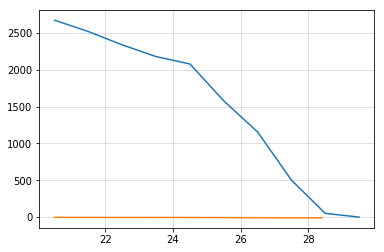

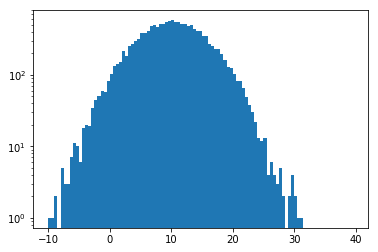

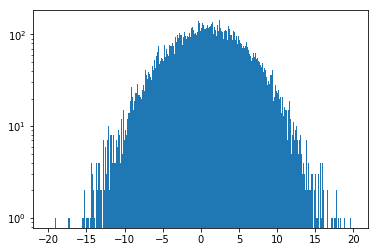

In [19]:
agn_lum = 10**mcmc_sample_from_pdf(agn_luminosity_function,30000,20,30,np.log10(agn_luminosity_function(1E20)),np.log10(agn_luminosity_function(1E29)))

bins = np.arange(20,30.1,1)
x = get_center(bins)
y,_ = np.histogram(np.log10(agn_lum),bins=bins)
plt.plot(x,y)

x = np.arange(20.5,28.5,0.1)
y = agn_luminosity_function(10**x)
plt.plot(x,np.log10(y))
plt.grid(alpha=0.5)
plt.show()

agn_lum_fir = 10**get_fir_lum(agn_lum,1,5)
y = np.log10(agn_lum_fir) - np.log10(3E26)
bins=np.arange(-10,40,0.5)
plt.hist(y,bins=bins,log=True)
plt.show()

Q = calc_Q(agn_lum_fir,agn_lum)
plt.hist(Q,bins=np.arange(-20,20,0.1),log=True)
plt.show()

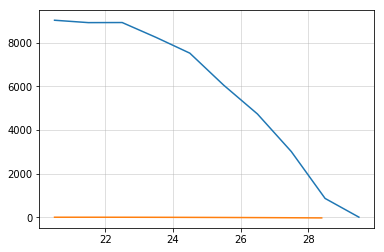

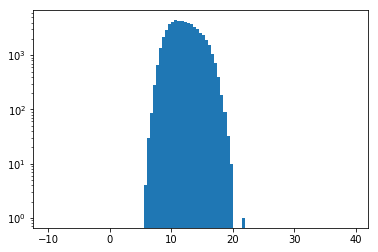

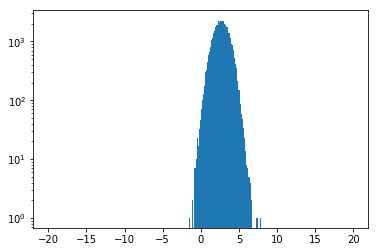

In [18]:
sf_lum = 10**mcmc_sample_from_pdf(sf_luminosity_function,100000,20,30,np.log10(sf_luminosity_function(1E20)),np.log10(sf_luminosity_function(1E29)))

bins = np.arange(20,30.1,1)
x = get_center(bins)
y,_ = np.histogram(np.log10(sf_lum),bins=bins)
plt.plot(x,y)

x = np.arange(20.5,28.5,0.1)
y = sf_luminosity_function(10**x)
plt.plot(x,np.log10(y))
plt.grid(alpha=0.5)
plt.show()

sf_lum_fir = 10**get_fir_lum(sf_lum,2.7,1)
y = np.log10(sf_lum_fir) - np.log10(3E26)
bins=np.arange(-10,40,0.5)
plt.hist(y,bins=bins,log=True)
plt.show()

Q = calc_Q(sf_lum_fir,sf_lum)
plt.hist(Q,bins=np.arange(-20,20,0.1),log=True)
plt.show()

In [15]:
rad_lum = np.log10(np.concatenate([agn_lum,sf_lum]))
fir_lum = np.log10(np.concatenate([agn_lum_fir,sf_lum_fir])/3E26)
detection = fir_lum>8.5

/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


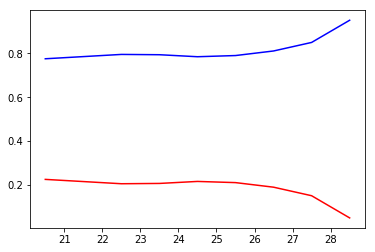

In [16]:
bins=np.arange(20,30.1,1)
rad_sf_binned,_  = np.histogram(np.log10(sf_lum),bins=bins)
rad_agn_binned,_ = np.histogram(np.log10(agn_lum),bins=bins)
rad_binned,_ = np.histogram(rad_lum,bins=bins)
plt.plot(get_center(bins),rad_sf_binned/rad_binned,c='blue')
plt.plot(get_center(bins),rad_agn_binned/rad_binned,c='red')
plt.show()

In [17]:
print(bins)
rad_sf_binned/rad_binned

[20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30.]


/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


array([0.77535488, 0.78525725, 0.79520114, 0.79381736, 0.78466077,
       0.79006656, 0.81094866, 0.84991374, 0.95124594,        nan])

/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  
/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/numpy/lib/histograms.py:1097: RuntimeWarning: invalid value encountered in true_divide
  hist /= s
/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/matplotlib/colors.py:1028: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: divide by zero encountered in log
  resdat -= np.log(vmin)
/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/matplotlib/colors.py:1032: RuntimeWarning: divide by zero encountered in log
  resdat /= (np.log(vmax) - np.log(vmin))


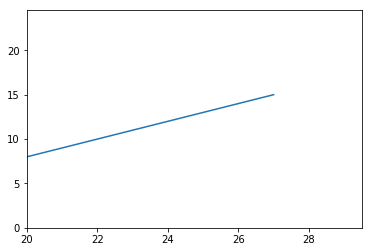

In [20]:
x = np.log10(rad_lum)
y = np.log10(fir_lum/3.8E26)
xbin = np.arange(20,30,0.5)
ybin = np.arange(0,25,0.5)
plot,_,_ = np.histogram2d(x,y,bins=(xbin,ybin))
#plt.imshow(np.log10(plot))
plt.hist2d(x,y,bins=(xbin,ybin),norm=LogNorm(),normed=True)
x = np.arange(20,28,1)
y = 1*x - 12
plt.plot(x,y)
plt.show()

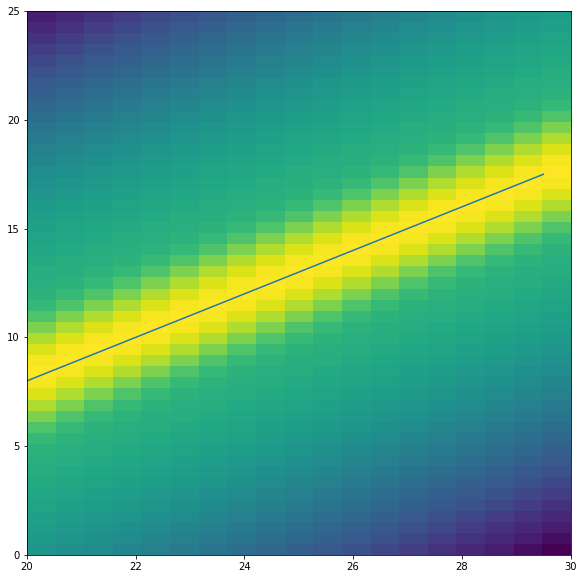

In [21]:
x = get_center(np.arange(20,30,0.5))
y = get_center(np.arange(0,25,0.5))
xbin,ybin = np.meshgrid(x,y)
params_sf = [1,-12,1]
params_agn = [1,-12,5]
plot_model = 10/13*straight_line_gaus(xbin,ybin,params_sf) + 3/13*straight_line_gaus(xbin,ybin,params_agn)
normalise_model = (plot_model/2)
fig = plt.figure(figsize=[10,10])
ax = plt.axes()
ax.imshow(np.log10(plot_model),extent=[20,30,25,0],aspect=10/25)
ax.invert_yaxis()

x = np.arange(20,30,0.5)
y = 1*x - 12
ax.plot(x,y)

plt.show()

In [22]:
xbin = np.arange(20,30.1,0.5)
ybin = np.arange(0,25.1,0.5)
data,_,_ = np.histogram2d(rad_lum,fir_lum,bins=[xbin,ybin])
normalise_data = (data.transpose()/np.sum(data,axis=1)).transpose()

/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [23]:
plot = normalise_data.transpose() - normalise_model
fig = plt.figure(figsize=[10,10])
ax = plt.axes()
im = ax.imshow(plot,extent=[20,30,25,0],aspect=10/25)
ax.invert_yaxis()

plt.colorbar(im)
plt.plot()

ValueError: operands could not be broadcast together with shapes (50,20) (49,19) 

In [28]:
params = ['m_sf','c_sf','sig_sf','m_agn','c_agn','sig_agn',
         'sf_prop_0','sf_prop_1','sf_prop_2','sf_prop_3','sf_prop_4','sf_prop_5','sf_prop_6',
         'sf_prop_7','sf_prop_8','sf_prop_9']
nwalkers = 40  # number of individual chains to make
ndim     = len(params) # number of dimensions
preburns = 200  # length of "burn-in" period to be discarded
burns    = 200 # number of iterations to be used after initial burn-in.

In [29]:
[1,-11.2,1,1,-12.9,5,0.7808399 , 0.78290812, 0.79130222, 0.7884932 , 0.78284672,
       0.78680677, 0.82699501, 0.84647962, 0.93450185,0.1]

[1,
 -11.2,
 1,
 1,
 -12.9,
 5,
 0.7808399,
 0.78290812,
 0.79130222,
 0.7884932,
 0.78284672,
 0.78680677,
 0.82699501,
 0.84647962,
 0.93450185,
 0.1]

In [30]:
PRIORS = {     'm_sf'   :  [ 0.9   ,   1.1 ] ,
               'c_sf'   :  [-12,-11],
               'sig_sf'   :  [ 0.9   ,   1.1 ] ,
               'm_agn'    :  [  0.9   ,    1.1 ] ,
               'c_agn'    :  [-13,-12],
               'sig_agn'    :  [  4   ,    6 ] ,
          'sf_prop_0'   :  [0.75,0.8],
         'sf_prop_1'    :  [  0.75   ,    0.8 ],
         'sf_prop_2'    :  [0.75   ,    0.8],
         'sf_prop_3'    :  [0.75   ,    0.8],
         'sf_prop_4'    :  [0.75   ,    0.8],
         'sf_prop_5'    :  [0.75   ,    0.8],
         'sf_prop_6'    :  [  0.8   ,    0.85 ],
         'sf_prop_7'    :  [  0.8   ,    0.85 ],
         'sf_prop_8'    :  [  0.9   ,    0.95 ],
         'sf_prop_9'    :  [  0   ,    0.01 ]}

In [42]:
PRIORS = {     'm_sf'   :  [ 0   ,   2 ] ,
               'c_sf'   :  [-20,0],
               'sig_sf'   :  [ 0   ,   2 ] ,
               'm_agn'    :  [  0   ,    2 ] ,
               'c_agn'    :  [-20,0],
               'sig_agn'    :  [  0   ,    10 ] ,
          'sf_prop_0'   :  [0,1],
         'sf_prop_1'    :  [  0   ,    1 ],
         'sf_prop_2'    :  [  0   ,    1 ],
         'sf_prop_3'    :  [  0   ,    1 ],
         'sf_prop_4'    :  [  0   ,    1 ],
         'sf_prop_5'    :  [  0   ,    1 ],
         'sf_prop_6'    :  [  0   ,    1 ],
         'sf_prop_7'    :  [  0   ,    1 ],
         'sf_prop_8'    :  [  0   ,    1 ],
         'sf_prop_9'    :  [  0   ,    1 ]}

In [43]:
def lnprior(theta):

    P = np.zeros(len(theta))

    for i,p in enumerate(params):
        if ( PRIORS[p][0]<= theta[i] <= PRIORS[p][1] ): 
            P[i] = 1.0
        else:
            P[i] = 0.0
            
    # return the log of the probability, in this case either log of 1 or 0.
    if np.product(P) == 0.0: 
        return(-np.inf)
        #return(0.0)
    else: 
        return(0.0)
        #return(1.0)
    
def lnlike(theta,x,y):
    #return(-0.5*sum( ( y-model( x, theta  ) )**2))
    #plt.scatter(x,y)
    #plt.plot(x,model(x,theta))
    #plt.show()
    
    m_sf,c_sf,sig_sf,m_agn,c_agn,sig_agn,sf_prop_0,sf_prop_1,sf_prop_2,sf_prop_3,sf_prop_4,sf_prop_5,sf_prop_6,sf_prop_7,sf_prop_8,sf_prop_9 = theta
    params_sf  = [m_sf,c_sf,sig_sf]
    params_agn = [m_agn,c_agn,sig_agn]
    sf_prop = np.array([sf_prop_0,sf_prop_1,sf_prop_2,sf_prop_3,sf_prop_4,sf_prop_5,sf_prop_6,sf_prop_7,sf_prop_8,sf_prop_9])
    
    bins = np.arange(20,30,1)
    sf_prop_bins_in = np.digitize(x,bins=bins)
    #NEED TO ACCOUNT FOR ERRORS ON BINS WITH NO DATA IN THEM WHICH ARE GIVEN AN ERROR OF 0
    model = sf_prop[sf_prop_bins_in-1]*straight_line_gaus(x,y,params_sf) + (1-sf_prop[sf_prop_bins_in-1])*straight_line_gaus(x,y,params_agn)
    

    lnlike = np.log(model)
    lnlike = np.sum(lnlike)

    return(lnlike)
    
def lnmissing(theta,x_y_mis,theta_sel):
    
    '''dx = 0.01
    x = np.arange(-20,20,dx)
    area = 0
    for n in range(len(x)-1):
        y1 = model(x[n],theta) * selection(x[n],theta_sel)
        y2 = model(x[n+1],theta) * selection(x[n+1],theta_sel)
        y_avg = (y1+y2)/2
        area = y_avg*dx + area
    lnmissing = area*n_missing'''
    
    for n,val in enumerate(theta_sel):
        theta = np.insert(theta,len(theta),val)

    xbin = np.arange(20,30,0.1)
    ybin = np.arange(0,25,0.1)
    ybin,xbin = np.meshgrid(xbin,ybin)
    model = straight_line_gaus_with_selection(xbin,ybin,theta)
    
    #this np.trapz could be doing something wrong so if there is a bug this is somewhere to check
    int_first = np.trapz(model,dx=0.1,axis=0)

    x_mis_dist,_ = np.histogram(x_y_mis,bins=np.arange(20,30.001,0.1))
    prob_mis = x_mis_dist*int_first
    mask = prob_mis==0
    prob_mis[mask] = 1-int_first[mask]
    #int_sec = np.trapz(int_first,dx=0.01)
    lnmissing = np.sum(np.log(prob_mis))
    return(lnmissing)

def find_pdf_normalisation(theta,x,y):
    m_sf,c_sf,sig_sf,m_agn,c_agn,sig_agn,sf_prop_1,sf_prop_2,sf_prop_3,sf_prop_4,sf_prop_5,sf_prop_6,sf_prop_7,sf_prop_8,sf_prop_9 = theta
    params_sf  = [m_sf,c_sf,sig_sf]
    params_agn = [m_agn,c_agn,sig_agn]
    sf_prop = np.array([sf_prop_0,sf_prop_1,sf_prop_2,sf_prop_3,sf_prop_4,sf_prop_5,sf_prop_6,sf_prop_7,sf_prop_8,sf_prop_9])
    
    xrng = np.arange(20,30,0.1)
    yrng = np.arange(0,25,0.1)
    xbin,ybin = np.meshgrid(xrng,yrng)
    which_sf_prop = np.digitize(xrng,bins=np.arange(20,30,1))
    model_fit = sf_prop[which_sf_prop-1]*straight_line_gaus(xbin,ybin,params_sf) + (1-sf_prop[which_sf_prop-1])*straight_line_gaus(xbin,ybin,params_agn)
    int_first = np.trapz(model_fit,dx=0.1,axis=0)
    model_volume = np.trapz(int_first,dx=0.1)
    print('normalisation is is: {}'.format(model_volume))
    return(model_volume)

def lnprob(theta,x,y,x_y_mis,theta_sel):
    

    #print(theta)
    lp = lnprior(theta)
    #print('lp is: {}'.format(lp))
    ll = lnlike(theta,x,y)
    #print('ll is: {}'.format(ll))
    lm = lnmissing(theta,x_y_mis,theta_sel)
    #lm=1
    #print(lm)

    if not np.isfinite(lp) or not np.isfinite(ll) or not np.isfinite(lm):
        return -np.inf
    else:
        #print('likelihood is: {}'.format(lp + ll + lm))
        return lp + ll + lm

In [53]:
theta = [np.percentile(samples[:,i],50) for i in range(ndim)]
#theta = theta_narrow_prior
print(lnmissing(theta,x_y_mis,[8.5,0.01]))
print(lnlike(theta,rad_lum[detection],fir_lum[detection]))
print(lnprob(theta,rad_lum[detection],fir_lum[detection],x_y_mis,[8.5,0.01]))

print('-----------------')

theta = np.array([  0.99805629, -11.53417439,   0.98216711,   1.03575265,
       -13.29966024,   4.94075926,   0.76156029,   0.78116264,
         0.80170808,   0.80833497,   0.79669142,   0.77181826,
         0.84973138,   0.84796675,   0.92786891,   0.        ])
print(lnprior(theta))
print(lnmissing(theta,x_y_mis,[8.5,0.01]))
print(lnlike(theta,rad_lum[detection],fir_lum[detection]))
print(lnprob(theta,rad_lum[detection],fir_lum[detection],x_y_mis,[8.5,0.01]))
print('-----------------')

theta = np.array([1,-11.2,1,1,-12.9,5,0.7808399 , 0.78290812, 0.79130222, 0.7884932 , 0.78284672,
       0.78680677, 0.82699501, 0.84647962, 0.93450185,0.0])
print(lnprior(theta))
print(lnmissing(theta,x_y_mis,[8.5,0.01]))
print(lnlike(theta,rad_lum[detection],fir_lum[detection]))
print(lnprob(theta,rad_lum[detection],fir_lum[detection],x_y_mis,[8.5,0.01]))

-1023.3161060921885
-112156.86165424908
-113180.17776034126
-----------------
0.0
-1307.8769829129456
-118828.03265029645
-120135.90963320939
-----------------
0.0
-1261.720604676049
-114879.34223149912
-116141.06283617517


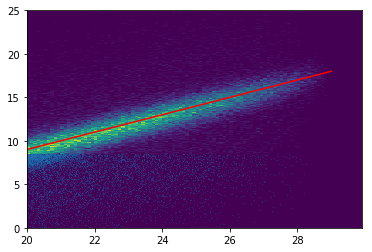

In [45]:
xdata = rad_lum[detection]
ydata = fir_lum[detection]
mask = fir_lum<8
x_y_mis = rad_lum[~detection] 
plt.hist2d(xdata,ydata,bins=[np.arange(20,30,0.1),np.arange(0,25,0.1)])
plt.scatter(x_y_mis,fir_lum[~detection],s=0.01)

x = np.arange(20,30,1)
y = x-11
plt.plot(x,y,c='red')

plt.ylim(0,25)
plt.show()

In [46]:
theta_true = np.array([  1.        , -11.2       ,   1.        ,   1.        ,
       -12.9       ,   5.        ,   0.7808399 ,   0.78290812,
         0.79130222,   0.7884932 ,   0.78284672,   0.78680677,
         0.82699501,   0.84647962,   0.93450185,   0.        ])

In [47]:
xdata = rad_lum[detection]
ydata = fir_lum[detection]
x_y_mis = rad_lum[~detection] 

start_val = []
for n in range(nwalkers) :
    sig = abs(theta_true/50)
    noise = np.random.normal(0,sig,len(sig))
    temp = theta_true + noise
    for i,p in enumerate(params):
        if ( PRIORS[p][0]<= temp[i] <= PRIORS[p][1] ):()
        else:
            temp[i] = PRIORS[p][1]
    start_val.append(temp)



pos = np.zeros((nwalkers,ndim))  + start_val
#pos = np.zeros((nwalkers,ndim))  + theta_true
#start_pos = np.zeros((nwalkers,ndim))
print(pos)


'''for j,p in enumerate(params):
    # I'm choosing to uniformally but randomly distribute them within the prior range.
    # you might choose something more systematic but I find for good prior choices this works well.
    pos[:,j] = np.random.rand(nwalkers)*(PRIORS[params[j]][1]-PRIORS[params[j]][0]) + PRIORS[params[j]][0]

'''
sampler = emcee.EnsembleSampler( nwalkers, ndim, lnprob, args=[xdata,ydata,x_y_mis,[8.5,0.01]] )

time0 = time.time()
print('MCMC start ')

pos, prob, state = sampler.run_mcmc(pos, burns+preburns )

time1=time.time()
print('MCMC end, Time taken: ',time1-time0)
samples = sampler.chain[:, preburns:, :].reshape(-1, ndim)

[[  0.98394027 -11.00092908   0.97409366   1.00531477 -13.2433152
    4.88183374   0.77407275   0.77190285   0.77345871   0.7580441
    0.75480026   0.80367833   0.79128823   0.85625012   0.92361191
    0.        ]
 [  0.99482529 -11.10242485   1.03126164   1.03040014 -13.1792939
    5.14125323   0.76205214   0.7804382    0.80319185   0.76137794
    0.78072904   0.76191367   0.82098783   0.85478407   0.92520519
    0.        ]
 [  0.94982737 -11.10358891   0.99116409   0.99321491 -12.82184336
    5.02159867   0.79004262   0.78594731   0.79085681   0.76495396
    0.77664385   0.80116474   0.85740986   0.84625302   0.94543113
    0.        ]
 [  1.00222751 -11.14817745   0.99603174   0.97678835 -13.32373788
    5.08490425   0.74409324   0.809911     0.80605509   0.79214262
    0.77896819   0.78270895   0.82761874   0.85826804   0.95050605
    0.        ]
 [  0.99904199 -11.40028053   1.00841959   1.00401578 -13.17650439
    5.16708124   0.77705949   0.75749625   0.76649482   0.78933614
 

/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in log


MCMC end, Time taken:  175.4740710258484


In [48]:
probs = []
for n,chain in enumerate(sampler.chain[:,:,:]):

    prob_chain = []
    for m,var in enumerate(chain):

        prob_chain = prob_chain + [lnprob(var,xdata,ydata,x_y_mis,[8.5,0.01])]
    probs.append(prob_chain)
    #lnprob(samples,xdata,ydata,x_y_mis,[8.5,0.01])


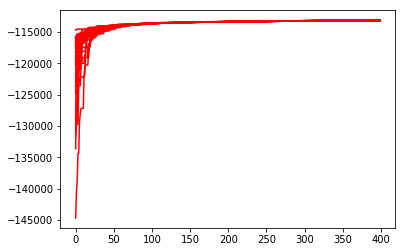

In [49]:
np.array(probs[0]).shape
for chain in probs:
    plt.plot(chain,c='red')
plt.show()

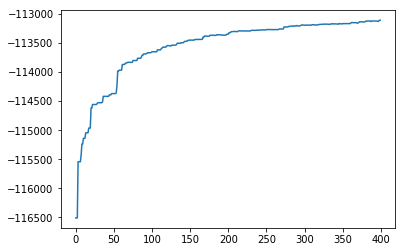

In [50]:
plt.plot(probs[0])

In [51]:
sampler.chain[1,:,:][0]

array([  0.99482529, -11.10242485,   1.03126164,   1.03040014,
       -13.1792939 ,   5.14125323,   0.76205214,   0.7804382 ,
         0.80319185,   0.76137794,   0.78072904,   0.76191367,
         0.82098783,   0.85478407,   0.92520519,   0.        ])

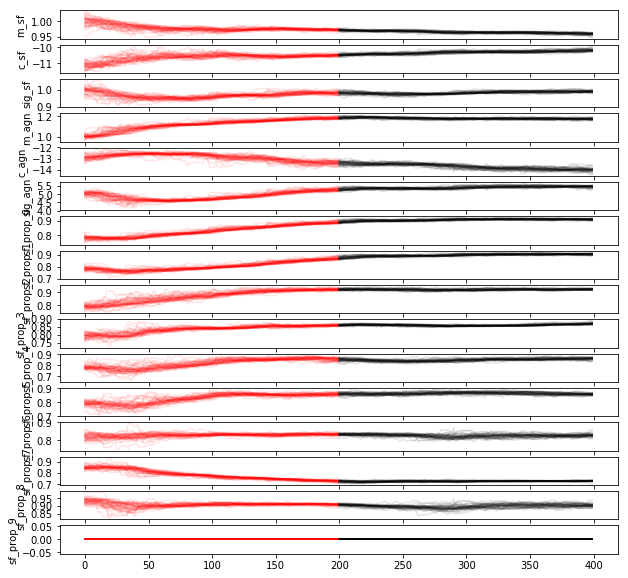

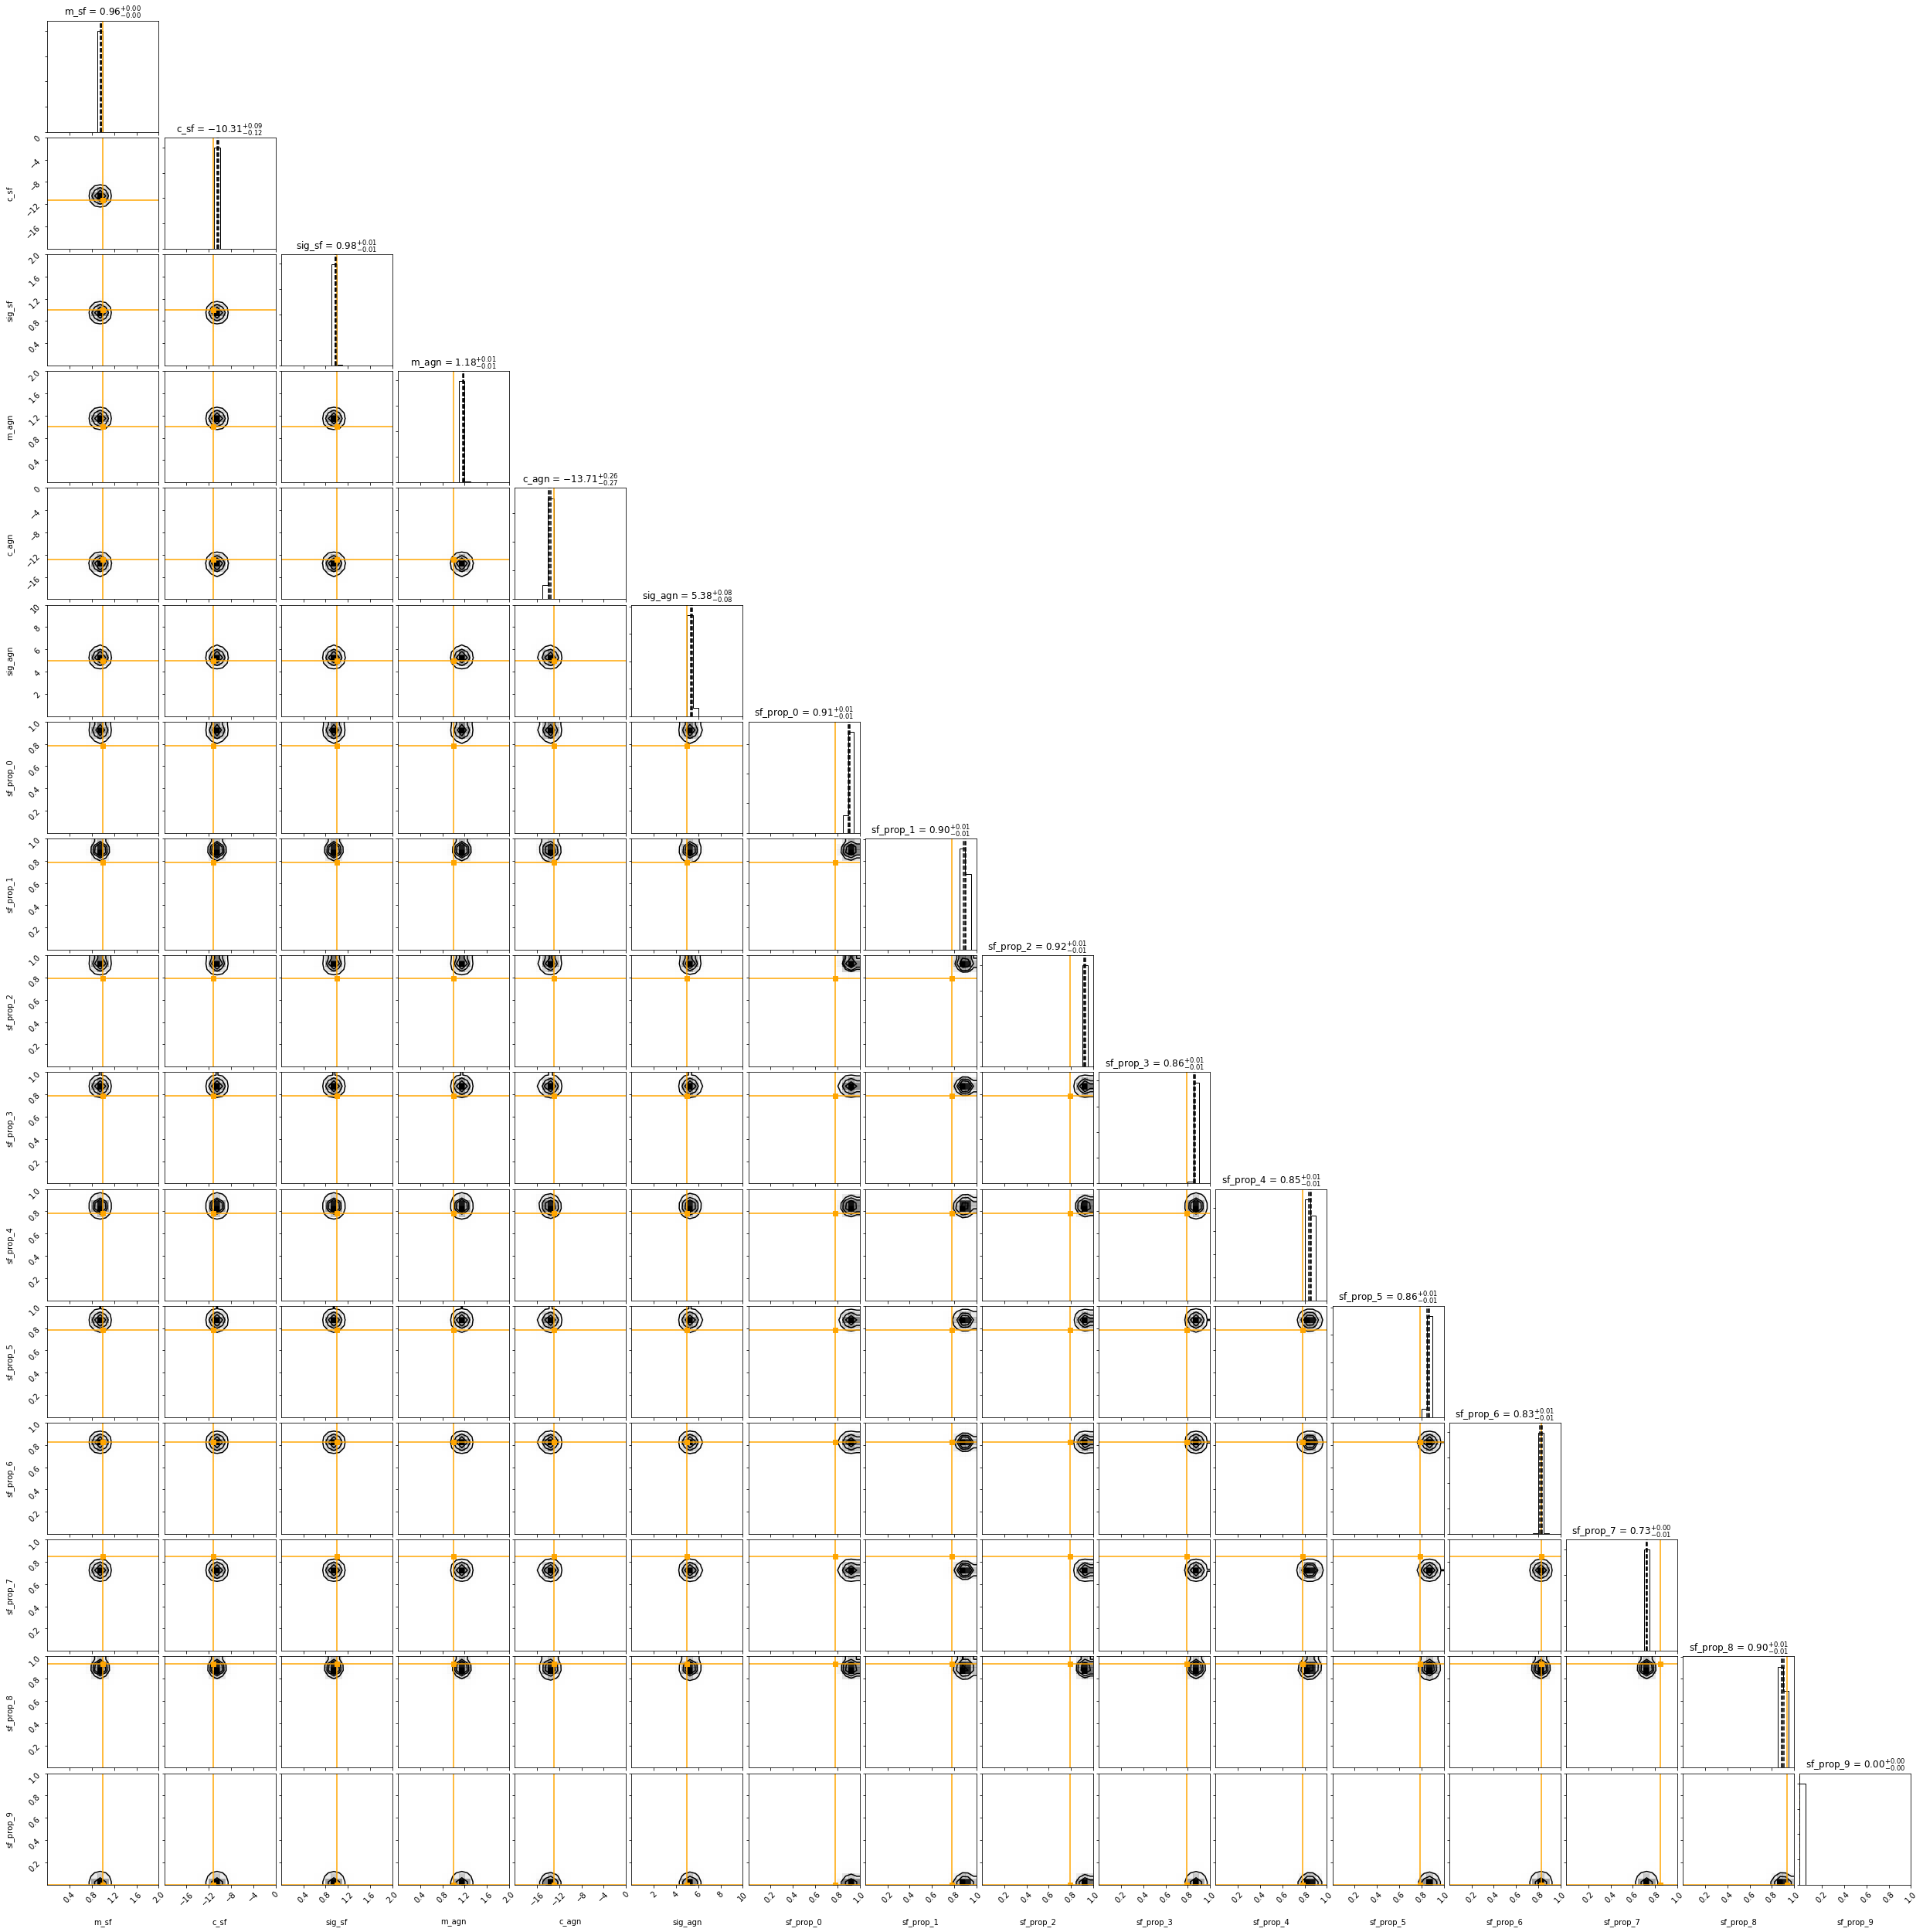

In [52]:
theta_true = np.array([1,-11.2,1,1,-12.9,5,0.7808399 , 0.78290812, 0.79130222, 0.7884932 , 0.78284672,
       0.78680677, 0.82699501, 0.84647962, 0.93450185,        0])

fig2,axarr = plt.subplots( ndim,1 ,figsize=(10,10))

for j in range(ndim):
    for i in range(nwalkers):
        axarr[j].plot( np.arange(0, preburns ,1) , sampler.chain[i,:preburns,j] , alpha=0.1, color='r' )
        axarr[j].plot( np.arange(preburns, burns+preburns ,1) , sampler.chain[i,preburns:,j] , alpha=0.1, color='k' )

    axarr[j].set_ylabel( params[j] )

import corner
fig = corner.corner(samples, labels= params , truths = theta_true, truth_color='orange', show_titles=True,\
        quantiles=[.16,.50,.84], smooth=1.0, \
        range = [(PRIORS[i][0],PRIORS[i][1]) for i in params])

In [ ]:
plt.plot(median_params[6:],c='red')
plt

In [41]:
median_params =   [np.percentile(samples[:,i],50) for i in range(ndim)]
#median_params = [1,-12,1,1,-12,5,10/13]
x = np.arange(20.5,29.5,1)
y = np.arange(0.5,24.5,1)
xbin,ybin = np.meshgrid(x,y)

params_sf = median_params[:3]
params_agn = median_params[3:6]
sf_prop = np.array(median_params[6:])
fitted_data = sf_prop*straight_line_gaus(xbin,ybin,params_sf) + (1-sf_prop)*straight_line_gaus(xbin,ybin,params_agn)


plt.plot(ybin,fitted_data)
plt.show()

x = np.arange(20,30,1)
y = np.arange(0,25,1)
binned_data,_,_ = np.histogram2d(rad_lum,fir_lum,bins=[x,y])
#binned_data = np.sum(binned_data,axis=0)
y = np.arange(0.5,24.5,1)
plt.plot(y,binned_data.transpose())
plt.show()

ValueError: operands could not be broadcast together with shapes (10,) (24,9) 

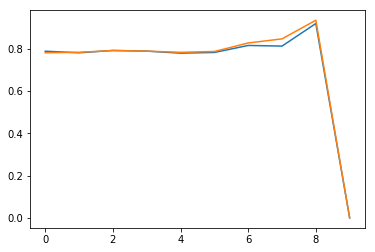

In [56]:
x = get_center(np.arange(20,30,1))
sf_prop = np.array(median_params[6:])
plt.plot(sf_prop)
plt.plot(theta_true[6:])

In [ ]:
median_params =   [np.percentile(samples[:,i],50) for i in range(ndim)]
median_params = [1,-12,1,1,-12,5,10/13]
x = np.arange(20,30,0.5)
y = np.arange(0,25,0.5)
xbin,ybin = np.meshgrid(x,y)

params_sf = median_params[:3]
params_agn = median_params[3:6]
sf_prop = median_params[-1]
fitted_data = sf_prop*straight_line_gaus(xbin,ybin,params_sf) + (1-sf_prop)*straight_line_gaus(xbin,ybin,params_agn)


plt.plot(ybin,normalise_data.transpose())
plt.show()

plt.plot(ybin,fitted_data)
plt.show()

In [ ]:
plt.plot(ybin,np.log(fitted_data))
#plt.plot(ybin,normalise_data.transpose(),c='red')

#plt.ylim(0,0.01)
plt.show()

In [ ]:
np.sum(normalise_data-fitted_data.transpose())

In [ ]:
normalise_data.transpose()

In [ ]:
fitted_data

In [ ]:
np.sum(normalise_data-fitted_data.transpose())

In [ ]:
np.sum((normalise_data-fitted_data.transpose())**2/error)

In [ ]:
np.sum(np.log((normalise_data-fitted_data.transpose())**2/error))